In [1]:
import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torchvision

import random
from torchvision import transforms, models
import torch.nn.functional as F

In [2]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


valid_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
train_path = 'path' # путь к данным
test_path = 'path'
valid_path = 'path'
n_classes=2

In [4]:
train_dataset = torchvision.datasets.ImageFolder(train_path, train_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_path, test_transforms)
valid_dataset = torchvision.datasets.ImageFolder(valid_path, valid_transforms)

In [5]:
batch_size = 5 #тут лучше поставить поменьше
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
len(train_dataloader), len(train_dataset), len(test_dataset), len(valid_dataset), len(test_dataloader)

(1480, 7400, 925, 925, 185)

In [7]:
X, y = next(iter(train_dataloader))
for i in range(batch_size):
  print(X.shape)

torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256])


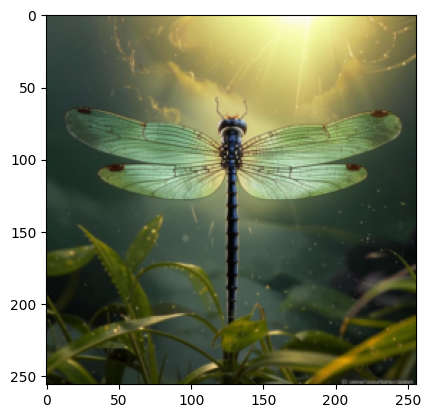

0 tensor(0)


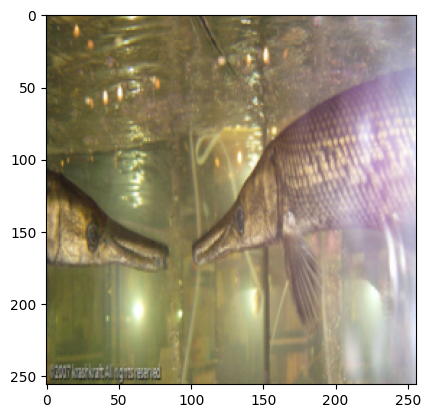

1 tensor(1)


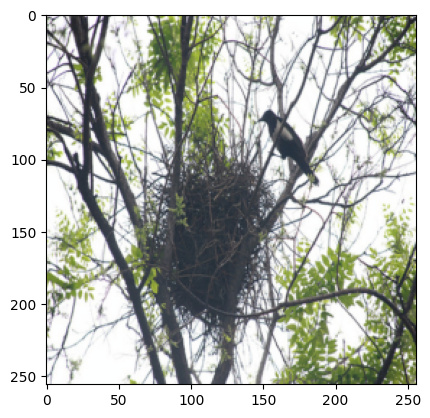

2 tensor(1)


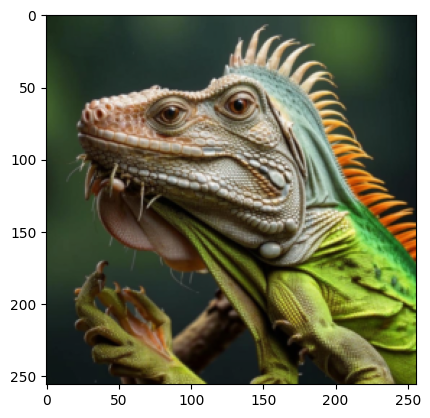

3 tensor(0)


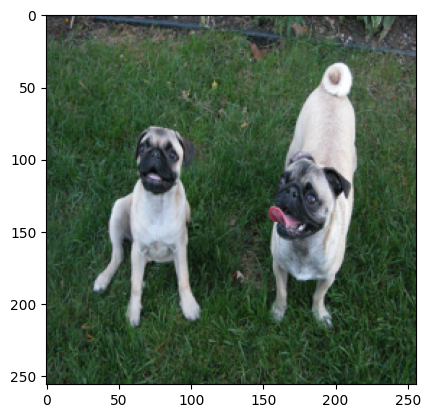

4 tensor(1)


In [8]:
X, y = next(iter(train_dataloader))
for i in range(batch_size):
  X.shape
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  plt.imshow(X[i].permute(1, 2, 0).numpy() * std + mean)
  plt.show()
  print(i, y[i])

In [13]:
def train(model, optimizer, loss_fn, train_loader, valid_loader, n_epochs=10): # Функция обучения

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        train_num_correct = 0
        train_num_examples = 0
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            train_num_correct += torch.sum(correct).item()
            train_num_examples += correct.shape[0]
        train_loss /= len(train_dataloader.dataset)

        model.eval()
        valid_num_correct = 0
        valid_num_examples = 0
        for batch in valid_dataloader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            valid_num_correct += torch.sum(correct).item()
            valid_num_examples += correct.shape[0]
        valid_loss /= len(valid_loader.dataset)

        print('Epoch: {}, train loss: {:.2f}, valid loss: {:.2f},train accuracy: {:.2f}, valid accuracy: {:.2f}'\
              .format(epoch, train_loss, valid_loss, train_num_correct / train_num_examples, valid_num_correct / valid_num_examples))

In [10]:
def test(model,test_dataloader): # Функция тест
    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in test_dataloader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]

    print('accuracy: {:.2f}'.format(num_correct/num_examples))


In [37]:
# Вариант 2 - Обучение предобученной сети

model = models.resnet50(pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [39]:
train(model, optimizer, loss_fn, train_dataloader, valid_dataloader, n_epochs=20)

Epoch: 1, train loss: 0.44, valid loss: 0.29,train accuracy: 0.82, valid accuracy: 0.88
Epoch: 2, train loss: 0.33, valid loss: 0.25,train accuracy: 0.86, valid accuracy: 0.90
Epoch: 3, train loss: 0.29, valid loss: 0.25,train accuracy: 0.88, valid accuracy: 0.90
Epoch: 4, train loss: 0.25, valid loss: 0.22,train accuracy: 0.90, valid accuracy: 0.92
Epoch: 5, train loss: 0.23, valid loss: 0.21,train accuracy: 0.90, valid accuracy: 0.91
Epoch: 6, train loss: 0.20, valid loss: 0.21,train accuracy: 0.92, valid accuracy: 0.93
Epoch: 7, train loss: 0.20, valid loss: 0.22,train accuracy: 0.92, valid accuracy: 0.92
Epoch: 8, train loss: 0.19, valid loss: 0.22,train accuracy: 0.92, valid accuracy: 0.90
Epoch: 9, train loss: 0.17, valid loss: 0.14,train accuracy: 0.94, valid accuracy: 0.94
Epoch: 10, train loss: 0.15, valid loss: 0.19,train accuracy: 0.94, valid accuracy: 0.92
Epoch: 11, train loss: 0.15, valid loss: 0.25,train accuracy: 0.94, valid accuracy: 0.90
Epoch: 12, train loss: 0.13, v

In [40]:
test(model,test_dataloader)

<ipython-input-10-226c5db2c416>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets)


accuracy: 0.97


ai
ai


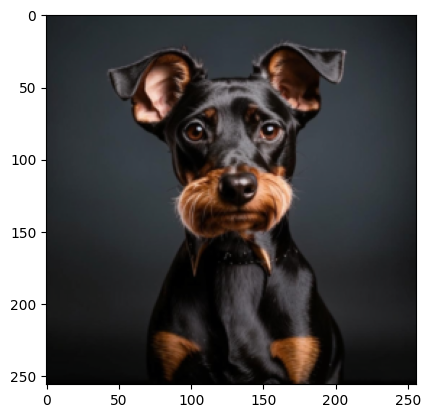

In [36]:
X, y = next(iter(test_dataloader))
output = model(X.to(device))
_, predicted = torch.max(output.data, 1)
print(train_dataset.classes[predicted[0]])
print(train_dataset.classes[y[0]])
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X[0].permute(1, 2, 0).numpy() * std + mean)


In [ ]:
torch.save(model,'/content/drive/MyDrive/model_checkpoint.pth')